In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader, Dataset

(16, 16, 3)


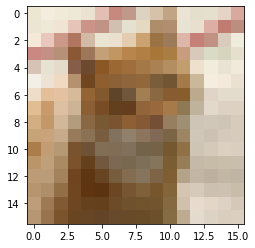

In [2]:
img = Image.open('Data/cat.jpg')
img = np.array(img.resize((16, 16)))
print(img.shape)
plt.imshow(img)
plt.show()

In [3]:
rs, cs, rys, gys, bys = [], [], [], [], []

for r in range(img.shape[0]):
  for c in range(img.shape[1]):
    rs.append(r)
    cs.append(c)
    rys.append(img[r,c,0]/255)
    gys.append(img[r,c,1]/255)
    bys.append(img[r,c,2]/255)

df = pd.DataFrame({'rs':rs, 'cs':cs, 'ry':rys, 'gy':gys, 'by':bys})
df

,rs,cs,ry,gy,by
0,0,0,0.925490,0.905882,0.827451
1,0,1,0.956863,0.929412,0.874510
2,0,2,0.945098,0.917647,0.850980
3,0,3,0.933333,0.909804,0.843137
4,0,4,0.925490,0.886275,0.823529
...,...,...,...,...,...
251,15,11,0.737255,0.670588,0.568627
252,15,12,0.894118,0.854902,0.803922
253,15,13,0.866667,0.827451,0.768627
254,15,14,0.854902,0.807843,0.749020


In [4]:
def PE_transform(X, Y=None, n=2):
    X = df.iloc[:, :-3].copy()
    Y = df.iloc[:, -3:].copy()
    for i in range(n):
        X[f'sin_2^{i+1}_rs'] = (X['rs']*(2**i)*np.pi/180).map(np.sin)
        X[f'cos_2^{i+1}_rs'] = (X['rs']*(2**i)*np.pi/180).map(np.cos)
        X[f'sin_2^{i+1}_cs'] = (X['cs']*(2**i)*np.pi/180).map(np.sin)
        X[f'cos_2^{i+1}_cs'] = (X['cs']*(2**i)*np.pi/180).map(np.cos)
    res = pd.concat([X, Y], axis=1)
    return res

In [5]:
def fit_model(df, epochs, lr):
    class MyDataset(Dataset):
        def __init__(self, df):
            x=df.iloc[:,0:-3].values
            y=df.iloc[:,-3:].values
            self.x_train=torch.tensor(x, dtype=torch.float32)
            self.y_train=torch.tensor(y, dtype=torch.float32)

        def __len__(self):
            return len(self.y_train)

        def __getitem__(self,idx):
            return self.x_train[idx], self.y_train[idx]

    DS=MyDataset(df)
    train_loader=DataLoader(DS,batch_size=len(DS), shuffle=True)

    class PE_model(nn.Module):
        def __init__(self, inp_size, out_size):
            super().__init__()
            self.hidden1 = nn.Linear(inp_size, 256)
            self.hidden2 = nn.Linear(256, 256)
            self.hidden3 = nn.Linear(256, 256)
            self.hidden4 = nn.Linear(256, 256)
            self.hidden5 = nn.Linear(256, 256)
            # self.act = nn.ReLU()
            self.act = nn.LeakyReLU()
            self.outact = nn.Sigmoid()
            self.output = nn.Linear(256, out_size)

        def forward(self, x):
            x = self.act(self.hidden1(x))
            x = self.act(self.hidden2(x))
            x = self.act(self.hidden3(x))
            x = self.act(self.hidden4(x))
            x = self.act(self.hidden5(x))
            # x = self.outact(self.output(x))
            x = self.output(x)
            return x

    model = PE_model(df.shape[1]-3, 3)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch: ', epoch, 'Loss:', loss.data)

    df_pred = df.iloc[:, :-3]
    X_pred = torch.tensor(df_pred.values, dtype=torch.float32)
    Y_pred = model(X_pred)
    Y_pred = torch.clamp(Y_pred, 0, 1)*255

    df_pred['ry_pred'] = Y_pred.data.numpy().astype(float)[:,0]
    df_pred['gy_pred'] = Y_pred.data.numpy().astype(float)[:,1]
    df_pred['by_pred'] = Y_pred.data.numpy().astype(float)[:,2]

    pred_img = np.zeros_like(img)
    for i in range(len(df_pred)):
        pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 0] = df_pred.loc[i, 'ry_pred']
        pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 1] = df_pred.loc[i, 'gy_pred']
        pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 2] = df_pred.loc[i, 'by_pred']

    return model, pred_img

Epoch:  0 Loss: tensor(0.3021)
Epoch:  1 Loss: tensor(0.2876)
Epoch:  2 Loss: tensor(0.2736)
Epoch:  3 Loss: tensor(0.2603)
Epoch:  4 Loss: tensor(0.2474)
Epoch:  5 Loss: tensor(0.2351)
Epoch:  6 Loss: tensor(0.2234)
Epoch:  7 Loss: tensor(0.2122)
Epoch:  8 Loss: tensor(0.2015)
Epoch:  9 Loss: tensor(0.1913)
Epoch:  10 Loss: tensor(0.1817)
Epoch:  11 Loss: tensor(0.1726)
Epoch:  12 Loss: tensor(0.1639)
Epoch:  13 Loss: tensor(0.1555)
Epoch:  14 Loss: tensor(0.1476)
Epoch:  15 Loss: tensor(0.1401)
Epoch:  16 Loss: tensor(0.1330)
Epoch:  17 Loss: tensor(0.1263)
Epoch:  18 Loss: tensor(0.1202)
Epoch:  19 Loss: tensor(0.1146)
Epoch:  20 Loss: tensor(0.1095)
Epoch:  21 Loss: tensor(0.1050)
Epoch:  22 Loss: tensor(0.1012)
Epoch:  23 Loss: tensor(0.0980)
Epoch:  24 Loss: tensor(0.0954)
Epoch:  25 Loss: tensor(0.0934)
Epoch:  26 Loss: tensor(0.0919)
Epoch:  27 Loss: tensor(0.0909)
Epoch:  28 Loss: tensor(0.0901)
Epoch:  29 Loss: tensor(0.0897)
Epoch:  30 Loss: tensor(0.0893)
Epoch:  31 Loss: t

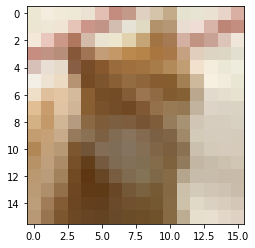

In [6]:
m1, pred1 = fit_model(df, 5000, lr=5e-5)
plt.imshow(pred1)

Epoch:  0 Loss: tensor(0.3816)
Epoch:  1 Loss: tensor(0.3739)
Epoch:  2 Loss: tensor(0.3664)
Epoch:  3 Loss: tensor(0.3592)
Epoch:  4 Loss: tensor(0.3522)
Epoch:  5 Loss: tensor(0.3455)
Epoch:  6 Loss: tensor(0.3391)
Epoch:  7 Loss: tensor(0.3327)
Epoch:  8 Loss: tensor(0.3263)
Epoch:  9 Loss: tensor(0.3200)
Epoch:  10 Loss: tensor(0.3137)
Epoch:  11 Loss: tensor(0.3072)
Epoch:  12 Loss: tensor(0.3007)
Epoch:  13 Loss: tensor(0.2940)
Epoch:  14 Loss: tensor(0.2873)
Epoch:  15 Loss: tensor(0.2804)
Epoch:  16 Loss: tensor(0.2734)
Epoch:  17 Loss: tensor(0.2664)
Epoch:  18 Loss: tensor(0.2592)
Epoch:  19 Loss: tensor(0.2518)
Epoch:  20 Loss: tensor(0.2443)
Epoch:  21 Loss: tensor(0.2366)
Epoch:  22 Loss: tensor(0.2288)
Epoch:  23 Loss: tensor(0.2209)
Epoch:  24 Loss: tensor(0.2128)
Epoch:  25 Loss: tensor(0.2047)
Epoch:  26 Loss: tensor(0.1965)
Epoch:  27 Loss: tensor(0.1883)
Epoch:  28 Loss: tensor(0.1799)
Epoch:  29 Loss: tensor(0.1716)
Epoch:  30 Loss: tensor(0.1633)
Epoch:  31 Loss: t

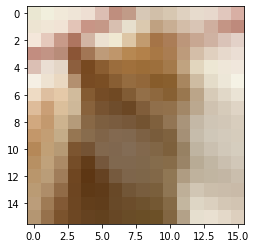

In [7]:
df_PE = PE_transform(df, 5)
m2, pred2 = fit_model(df_PE, 2000, lr=5e-5)
plt.imshow(pred2)